In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, arma_order_select_ic
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
%matplotlib inline

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.sqrt(np.mean((y_true - y_pred)**2))

def mae(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(np.abs(y_true - y_pred))

def mape(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.where(y_true==0, np.nan, y_true)
    return np.nanmean(np.abs((y_true - y_pred)/denom))*100


## Dataset 1: Monthly Retail Sales (for Regression & ETS)

In [2]:

# Create 4 years of monthly data
dates = pd.date_range('2021-01-01', '2024-12-31', freq='MS')
n_months = len(dates)
t = np.arange(n_months)

# Components
trend = 1000 + 15*t  # growing business
yearly_seasonal = 300*np.sin(2*np.pi*t/12) + 200*np.cos(2*np.pi*t/12)

# Holiday effects (Nov-Dec spike)
holiday_effect = np.zeros(n_months)
for year in range(4):
    nov_idx = year*12 + 10
    dec_idx = year*12 + 11
    if nov_idx < n_months:
        holiday_effect[nov_idx] = 400
    if dec_idx < n_months:
        holiday_effect[dec_idx] = 600

# Random noise
noise = np.random.normal(0, 80, n_months)

# Combine
sales = trend + yearly_seasonal + holiday_effect + noise
sales = np.maximum(sales, 0)

df_sales = pd.DataFrame({
    'Date': dates,
    'Sales': sales,
    'Month': dates.month,
    'Year': dates.year,
    'Time': t
}).set_index('Date')

print(f"Date range: {df_sales.index[0].date()} to {df_sales.index[-1].date()}")
print(f"Number of months: {len(df_sales)}")
print("\nSales Statistics:")
display(df_sales['Sales'].describe())


Date range: 2021-01-01 to 2024-12-01
Number of months: 48

Sales Statistics:


count      48.000000
mean     1419.409544
std       352.878551
min       722.634428
25%      1196.284168
50%      1393.908200
75%      1710.667034
max      2412.774859
Name: Sales, dtype: float64

## Part A: Regression and ETS Models
### A1: Exploratory Visualization

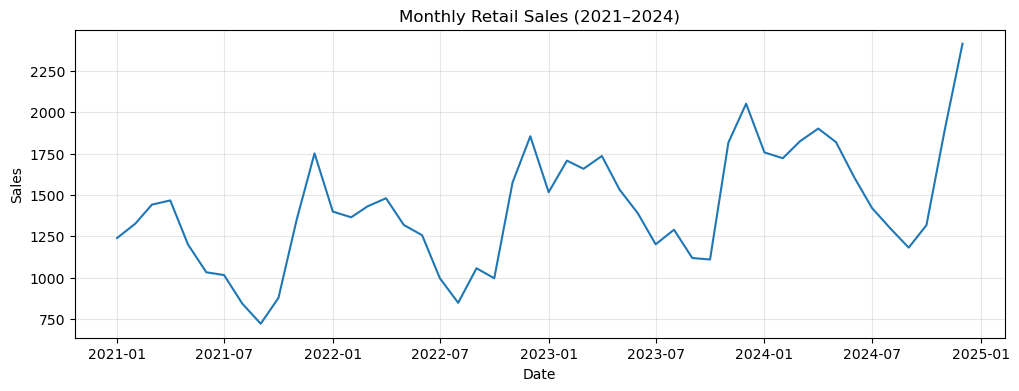

<Figure size 1000x400 with 0 Axes>

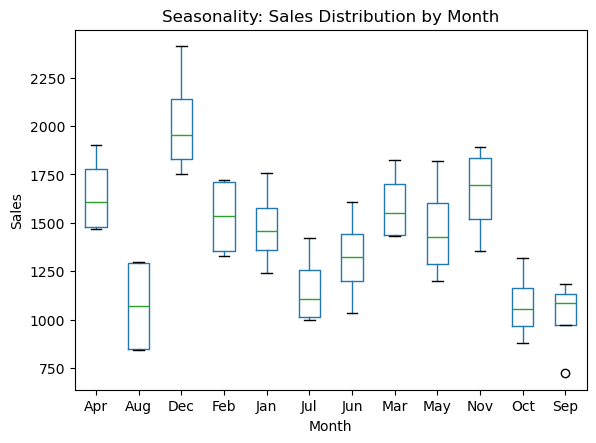

Average sales by month:


,AvgSales
MonthName,
Jan,1478.063146
Feb,1530.199239
Mar,1588.679443
Apr,1645.666032
May,1467.624489
Jun,1320.990617
Jul,1159.076677
Aug,1069.921030
Sep,1020.275482


Month with highest average sales: Dec


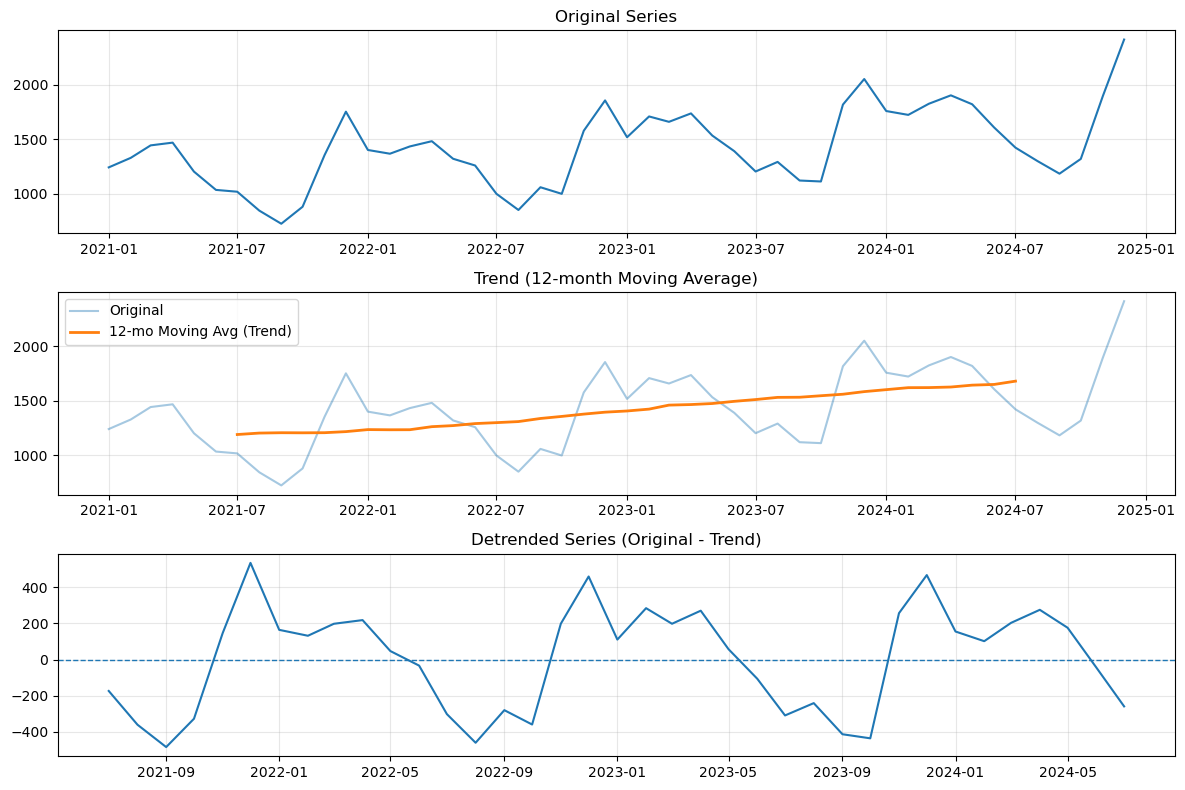

In [3]:

# 1) Full time series plot
plt.figure(figsize=(12,4))
plt.plot(df_sales.index, df_sales['Sales'])
plt.title("Monthly Retail Sales (2021–2024)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True, alpha=0.3)
plt.show()

# 2) Seasonal subseries / boxplot by month
month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
df_sales['MonthName'] = df_sales['Month'].map(dict(zip(range(1,13), month_names)))

plt.figure(figsize=(10,4))
df_sales.boxplot(column='Sales', by='MonthName', grid=False)
plt.title("Seasonality: Sales Distribution by Month")
plt.suptitle("")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.xticks(rotation=0)
plt.show()

avg_by_month = df_sales.groupby('MonthName')['Sales'].mean().reindex(month_names)
print("Average sales by month:")
display(avg_by_month.to_frame('AvgSales'))

print(f"Month with highest average sales: {avg_by_month.idxmax()}")

# 3) Conceptual decomposition: original, 12-month moving average trend, detrended
trend_ma12 = df_sales['Sales'].rolling(12, center=True).mean()
detrended = df_sales['Sales'] - trend_ma12

plt.figure(figsize=(12,8))

plt.subplot(3,1,1)
plt.plot(df_sales.index, df_sales['Sales'])
plt.title("Original Series")
plt.grid(True, alpha=0.3)

plt.subplot(3,1,2)
plt.plot(df_sales.index, df_sales['Sales'], alpha=0.4, label='Original')
plt.plot(df_sales.index, trend_ma12, linewidth=2, label='12-mo Moving Avg (Trend)')
plt.title("Trend (12-month Moving Average)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3,1,3)
plt.plot(df_sales.index, detrended)
plt.axhline(0, linestyle='--', linewidth=1)
plt.title("Detrended Series (Original - Trend)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### A2: Linear Regression with Trend and Seasonality (Month Dummies)

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     83.27
Date:                Wed, 11 Feb 2026   Prob (F-statistic):           4.66e-22
Time:                        17:34:44   Log-Likelihood:                -267.91
No. Observations:                  48   AIC:                             561.8
Df Residuals:                      35   BIC:                             586.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1225.9156     40.334     30.394      0.0

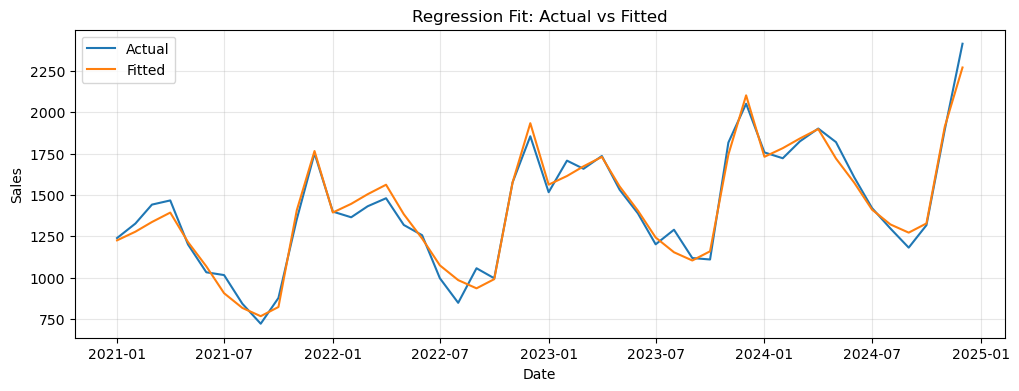

In [4]:

# Create seasonal dummies: 11 dummies (Jan baseline)
X_month = pd.get_dummies(df_sales['Month'], prefix='M', drop_first=True)
X = pd.concat([df_sales[['Time']], X_month], axis=1)
X = sm.add_constant(X)

# Ensure numeric dtypes for statsmodels
X = X.astype(float)
y = df_sales['Sales'].astype(float)

reg_dummy = sm.OLS(y, X).fit()
print(reg_dummy.summary())

# Interpret key pieces
beta1 = reg_dummy.params['Time']
print(f"\nEstimated monthly trend (beta1 on Time): {beta1:.3f} sales units per month")

# Largest seasonal effect relative to Jan
seasonal_coefs = reg_dummy.params.filter(like='M_')
largest_month = seasonal_coefs.idxmax()
print(f"Largest positive seasonal dummy coefficient: {largest_month} = {seasonal_coefs.max():.3f}")

# Fitted values and metrics
yhat = reg_dummy.fittedvalues
r2 = reg_dummy.rsquared
rmse_val = rmse(y, yhat)
mae_val = mae(y, yhat)

print(f"\nFit metrics (in-sample):")
print(f"R^2  = {r2:.4f}")
print(f"RMSE = {rmse_val:.3f}")
print(f"MAE  = {mae_val:.3f}")

plt.figure(figsize=(12,4))
plt.plot(df_sales.index, y, label='Actual')
plt.plot(df_sales.index, yhat, label='Fitted')
plt.title("Regression Fit: Actual vs Fitted")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


### A3: Fourier Terms for Seasonality (k=1,2)

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     52.94
Date:                Wed, 11 Feb 2026   Prob (F-statistic):           4.72e-17
Time:                        17:34:46   Log-Likelihood:                -301.46
No. Observations:                  48   AIC:                             614.9
Df Residuals:                      42   BIC:                             626.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1070.5202     40.011     26.755      0.0

,Model,R2,AIC,NumParams (incl intercept)
0,Month dummies,0.966160,561.821555,13
1,"Fourier (k=1,2)",0.863054,614.923282,6


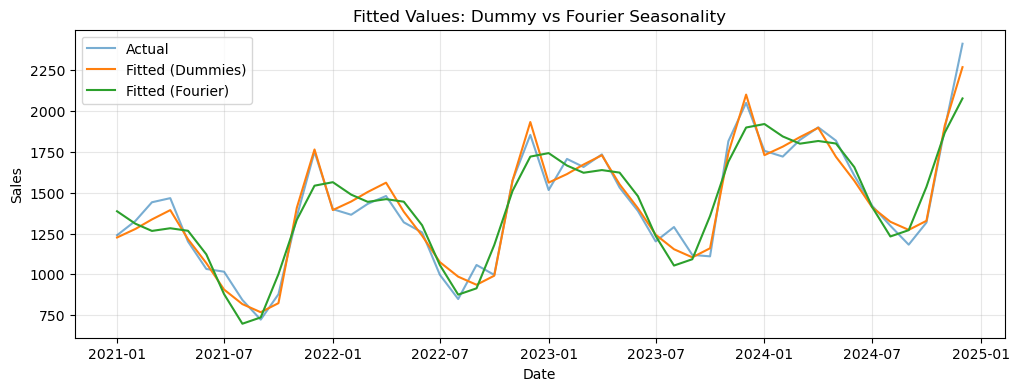

Preference (rule-of-thumb):
- Dummy model looks preferable: lower AIC (better in-sample information criterion).


In [5]:

m = 12
t = df_sales['Time'].values

# Fourier terms for k=1,2
fourier = pd.DataFrame(index=df_sales.index)
for k in [1,2]:
    fourier[f'sin{k}'] = np.sin(2*np.pi*k*t/m)
    fourier[f'cos{k}'] = np.cos(2*np.pi*k*t/m)

Xf = pd.concat([df_sales[['Time']], fourier], axis=1)
Xf = sm.add_constant(Xf)

reg_fourier = sm.OLS(y, Xf).fit()
print(reg_fourier.summary())

# Compare with dummy variable model
comp = pd.DataFrame({
    'Model': ['Month dummies', 'Fourier (k=1,2)'],
    'R2': [reg_dummy.rsquared, reg_fourier.rsquared],
    'AIC': [reg_dummy.aic, reg_fourier.aic],
    'NumParams (incl intercept)': [int(reg_dummy.df_model+1), int(reg_fourier.df_model+1)]
})
display(comp)

# Plot fitted values from both models
plt.figure(figsize=(12,4))
plt.plot(df_sales.index, y, alpha=0.6, label='Actual')
plt.plot(df_sales.index, reg_dummy.fittedvalues, label='Fitted (Dummies)')
plt.plot(df_sales.index, reg_fourier.fittedvalues, label='Fitted (Fourier)')
plt.title("Fitted Values: Dummy vs Fourier Seasonality")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Preference (rule-of-thumb): fewer parameters if fit is comparable
print("Preference (rule-of-thumb):")
if (reg_fourier.aic < reg_dummy.aic) and (int(reg_fourier.df_model+1) < int(reg_dummy.df_model+1)):
    print("- Fourier looks preferable: lower AIC with fewer parameters (more parsimonious).")
elif reg_dummy.aic < reg_fourier.aic:
    print("- Dummy model looks preferable: lower AIC (better in-sample information criterion).")
else:
    print("- Both are close; Fourier is often preferred for smooth seasonality and fewer parameters.")


### A4: Simple Exponential Smoothing (SES) on Deseasonalized Data

Optimized alpha (level smoothing): 0.4112

Holdout accuracy (12 months):
RMSE = 186.049
MAE  = 167.263
MAPE = 9.70%


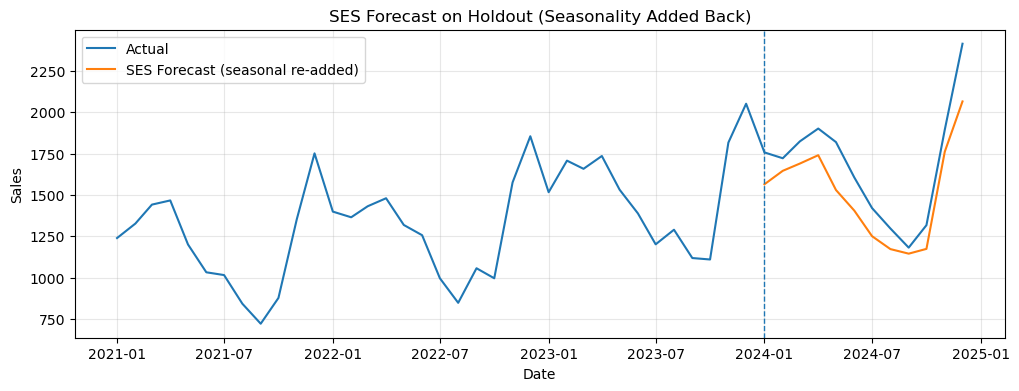

In [6]:

# Train/holdout split: first 36 months train, last 12 months test
train = df_sales.iloc[:36].copy()
test  = df_sales.iloc[36:].copy()

# Deseasonalize using seasonal averages from TRAIN
seasonal_avg = train.groupby(train.index.month)['Sales'].mean()
train['seasonal'] = train.index.month.map(seasonal_avg)
test['seasonal']  = test.index.month.map(seasonal_avg)

train['deseason'] = train['Sales'] - train['seasonal']
test['deseason']  = test['Sales'] - test['seasonal']

# Fit SES on deseasonalized data
ses_model = SimpleExpSmoothing(train['deseason']).fit(optimized=True)
alpha_opt = ses_model.model.params['smoothing_level']
print(f"Optimized alpha (level smoothing): {alpha_opt:.4f}")

# Forecast next 12 months (deseasonalized)
ses_fore_deseason = ses_model.forecast(12)

# Add seasonality back
ses_fore = ses_fore_deseason.values + test['seasonal'].values
ses_fore = pd.Series(ses_fore, index=test.index, name='SES_Forecast')

# Accuracy on holdout
print("\nHoldout accuracy (12 months):")
print(f"RMSE = {rmse(test['Sales'], ses_fore):.3f}")
print(f"MAE  = {mae(test['Sales'], ses_fore):.3f}")
print(f"MAPE = {mape(test['Sales'], ses_fore):.2f}%")

plt.figure(figsize=(12,4))
plt.plot(df_sales.index, df_sales['Sales'], label='Actual')
plt.plot(test.index, ses_fore, label='SES Forecast (seasonal re-added)')
plt.axvline(test.index[0], linestyle='--', linewidth=1)
plt.title("SES Forecast on Holdout (Seasonality Added Back)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


### A5: Holt’s Linear Trend Method (on Deseasonalized Data)

Optimized alpha (level): 0.2201
Optimized beta  (trend): 0.0000
Final level (l_T): 206.348
Final trend (b_T): 10.557

Holdout accuracy (12 months):
RMSE = 109.843
MAE  = 87.546
MAPE = 5.01%


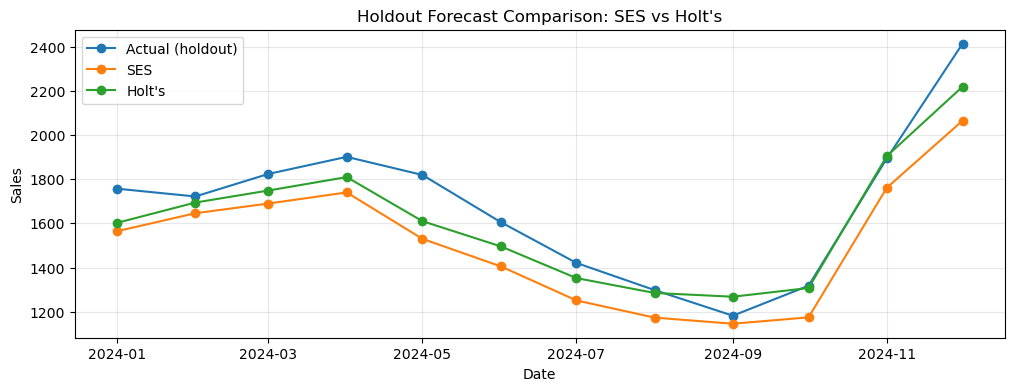


Which captures the trend better?
- Holt’s method includes an explicit trend component, so it usually tracks upward/downward movement better than SES.


In [7]:

holt_model = ExponentialSmoothing(train['deseason'], trend='add', seasonal=None).fit(optimized=True)

params = holt_model.model.params
alpha = params.get('smoothing_level', np.nan)
beta  = params.get('smoothing_trend', np.nan)
print(f"Optimized alpha (level): {alpha:.4f}")
print(f"Optimized beta  (trend): {beta:.4f}")

# Final state
level = holt_model.level[-1]
trend_comp = holt_model.trend[-1]
print(f"Final level (l_T): {level:.3f}")
print(f"Final trend (b_T): {trend_comp:.3f}")

# Forecast 12 months ahead (deseasonalized) then add seasonality back
holt_fore_deseason = holt_model.forecast(12)
holt_fore = holt_fore_deseason.values + test['seasonal'].values
holt_fore = pd.Series(holt_fore, index=test.index, name='Holt_Forecast')

print("\nHoldout accuracy (12 months):")
print(f"RMSE = {rmse(test['Sales'], holt_fore):.3f}")
print(f"MAE  = {mae(test['Sales'], holt_fore):.3f}")
print(f"MAPE = {mape(test['Sales'], holt_fore):.2f}%")

# Compare SES vs Holt forecasts
plt.figure(figsize=(12,4))
plt.plot(test.index, test['Sales'], marker='o', label='Actual (holdout)')
plt.plot(test.index, ses_fore, marker='o', label='SES')
plt.plot(test.index, holt_fore, marker='o', label="Holt's")
plt.title("Holdout Forecast Comparison: SES vs Holt's")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print("\nWhich captures the trend better?")
print("- Holt’s method includes an explicit trend component, so it usually tracks upward/downward movement better than SES.")


### A6: Holt-Winters Seasonal Method (Additive Seasonality)

Optimized alpha (level):   0.1694
Optimized beta  (trend):   0.1694
Optimized gamma (seasonal):0.0000


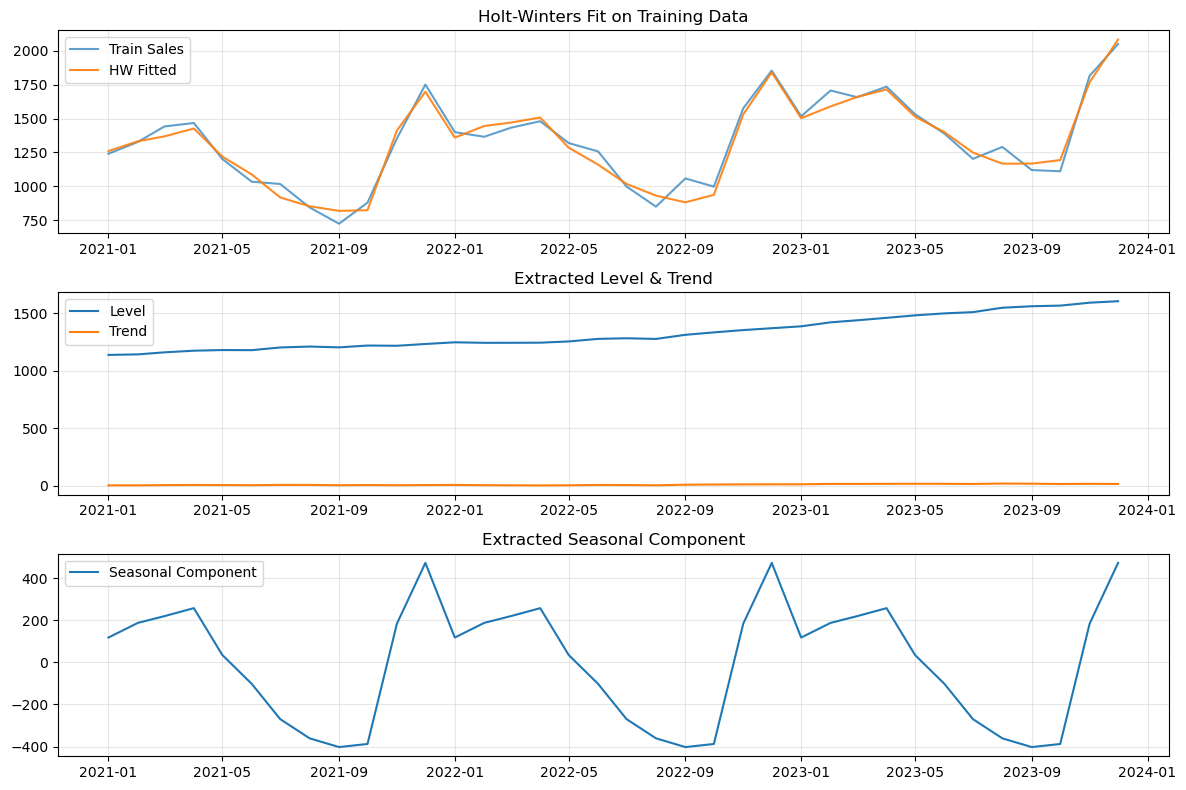


Holdout accuracy (12 months):
RMSE = 88.522
MAE  = 74.694
MAPE = 4.76%


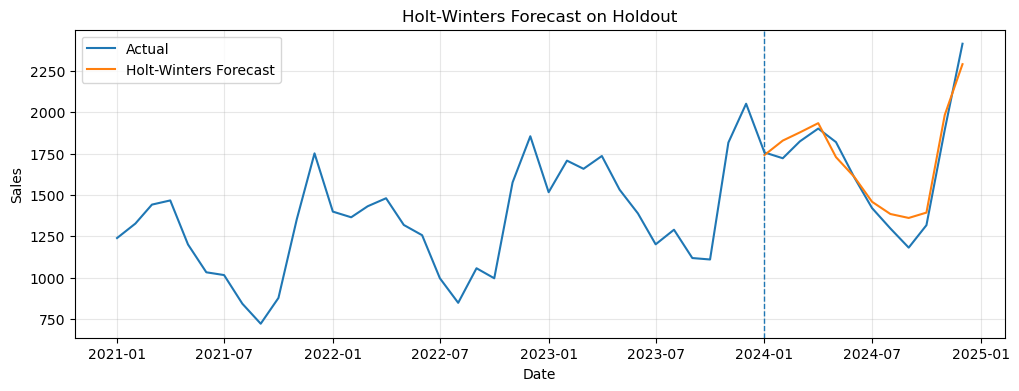


Holdout accuracy comparison (lower is better):


,Model,RMSE,MAE,MAPE%
0,Regression (dummies),61.581776,44.653795,2.627787
3,Holt-Winters,88.521767,74.693822,4.760575
2,Holt's (deseason+trend),109.843390,87.546218,5.013686
1,SES (deseason+SES),186.049109,167.263153,9.704848


Best on holdout by RMSE: Regression (dummies)


In [8]:

# Fit Holt-Winters on TRAIN with additive trend and seasonality
hw_model = ExponentialSmoothing(
    train['Sales'],
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit(optimized=True)

p = hw_model.model.params
alpha = p.get('smoothing_level', np.nan)
beta  = p.get('smoothing_trend', np.nan)
gamma = p.get('smoothing_seasonal', np.nan)
print(f"Optimized alpha (level):   {alpha:.4f}")
print(f"Optimized beta  (trend):   {beta:.4f}")
print(f"Optimized gamma (seasonal):{gamma:.4f}")

# Extract components (in-sample)
hw_level = hw_model.level
hw_trend = hw_model.trend
hw_season = hw_model.season

plt.figure(figsize=(12,8))
plt.subplot(3,1,1)
plt.plot(train.index, train['Sales'], label='Train Sales', alpha=0.7)
plt.plot(train.index, hw_model.fittedvalues, label='HW Fitted', alpha=0.9)
plt.title("Holt-Winters Fit on Training Data")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3,1,2)
plt.plot(train.index, hw_level, label='Level')
plt.plot(train.index, hw_trend, label='Trend')
plt.title("Extracted Level & Trend")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3,1,3)
plt.plot(train.index, hw_season, label='Seasonal Component')
plt.title("Extracted Seasonal Component")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Forecast 12 months ahead
hw_fore = hw_model.forecast(12)
hw_fore.name = 'HW_Forecast'

print("\nHoldout accuracy (12 months):")
print(f"RMSE = {rmse(test['Sales'], hw_fore):.3f}")
print(f"MAE  = {mae(test['Sales'], hw_fore):.3f}")
print(f"MAPE = {mape(test['Sales'], hw_fore):.2f}%")

plt.figure(figsize=(12,4))
plt.plot(df_sales.index, df_sales['Sales'], label='Actual')
plt.plot(test.index, hw_fore, label='Holt-Winters Forecast')
plt.axvline(test.index[0], linestyle='--', linewidth=1)
plt.title("Holt-Winters Forecast on Holdout")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Compare forecast accuracy across methods on the same holdout
# Regression (dummy) forecast for holdout using fitted coefficients
X_test_month = pd.get_dummies(test.index.month, prefix='M', drop_first=True)
X_test_month.index = test.index
X_test = pd.concat([test[['Time']], X_test_month], axis=1)
# align columns to training design matrix
X_test = X_test.reindex(columns=X.columns.drop('const'), fill_value=0)
X_test = sm.add_constant(X_test)
X_test = X_test.astype(float)
reg_fore = reg_dummy.predict(X_test)

acc = pd.DataFrame({
    'Model': ['Regression (dummies)', 'SES (deseason+SES)', "Holt's (deseason+trend)", 'Holt-Winters'],
    'RMSE': [rmse(test['Sales'], reg_fore), rmse(test['Sales'], ses_fore), rmse(test['Sales'], holt_fore), rmse(test['Sales'], hw_fore)],
    'MAE':  [mae(test['Sales'], reg_fore), mae(test['Sales'], ses_fore), mae(test['Sales'], holt_fore), mae(test['Sales'], hw_fore)],
    'MAPE%':[mape(test['Sales'], reg_fore), mape(test['Sales'], ses_fore), mape(test['Sales'], holt_fore), mape(test['Sales'], hw_fore)]
}).sort_values('RMSE')

print("\nHoldout accuracy comparison (lower is better):")
display(acc)

best = acc.iloc[0]['Model']
print(f"Best on holdout by RMSE: {best}")


## Part B: ARIMA Models
### Dataset 2: Daily Stock Returns (for ARIMA)

In [9]:

# Create 500 days of stock price data
n_days = 500
dates_stock = pd.date_range('2023-01-01', periods=n_days, freq='D')

# Generate AR(1) returns with noise
returns = np.zeros(n_days)
returns[0] = np.random.normal(0, 0.01)
phi = 0.05
for i in range(1, n_days):
    returns[i] = phi * returns[i-1] + np.random.normal(0, 0.015)

# Calculate price from returns (start at 100)
price = 100 * np.exp(np.cumsum(returns))

df_stock = pd.DataFrame({
    'Date': dates_stock,
    'Price': price,
    'Returns': returns * 100  # percent
}).set_index('Date')

print(f"Date range: {df_stock.index[0].date()} to {df_stock.index[-1].date()}")
print(f"Number of days: {len(df_stock)}")
print("\nPrice Statistics:")
display(df_stock['Price'].describe())


Date range: 2023-01-01 to 2024-05-14
Number of days: 500

Price Statistics:


count    500.000000
mean     115.002874
std       12.793924
min       94.210519
25%      102.898666
50%      115.340500
75%      125.312316
max      149.153080
Name: Price, dtype: float64

### B1: Stationarity Tests (Prices)

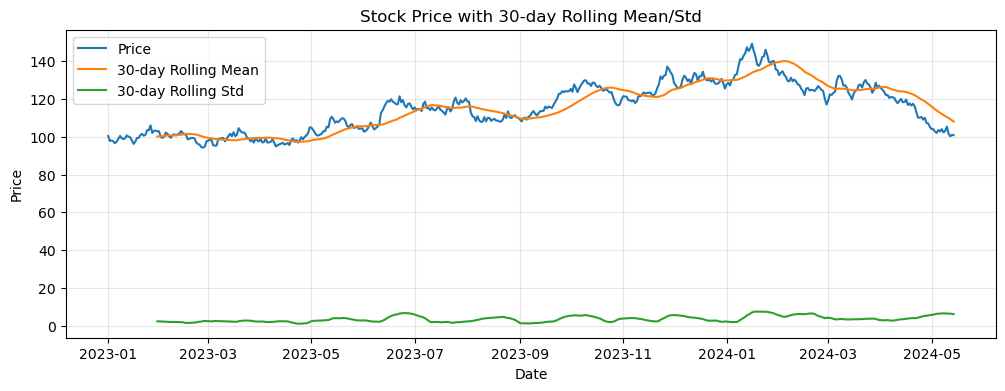

ADF test on Price:
  Test statistic: -1.5185
  p-value:        0.5243
  Critical values:{'1%': np.float64(-3.4435228622952065), '5%': np.float64(-2.867349510566146), '10%': np.float64(-2.569864247011056)}
  Decision @ 0.05: Fail to reject (non-stationary)

KPSS test on Price:
  Test statistic: 2.5618
  p-value:        0.0100
  Critical values:{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
  Decision @ 0.05: Reject stationarity (non-stationary)

Interpretation:
- Prices often behave like a random walk (non-stationary).
- If ADF fails to reject and KPSS rejects stationarity, they agree the series is non-stationary.


In [10]:

# Visual: price with rolling mean/std (30-day)
roll_mean = df_stock['Price'].rolling(30).mean()
roll_std  = df_stock['Price'].rolling(30).std()

plt.figure(figsize=(12,4))
plt.plot(df_stock.index, df_stock['Price'], label='Price')
plt.plot(df_stock.index, roll_mean, label='30-day Rolling Mean')
plt.plot(df_stock.index, roll_std, label='30-day Rolling Std')
plt.title("Stock Price with 30-day Rolling Mean/Std")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# ADF test on prices
adf_stat, adf_p, _, _, adf_crit, _ = adfuller(df_stock['Price'])
print("ADF test on Price:")
print(f"  Test statistic: {adf_stat:.4f}")
print(f"  p-value:        {adf_p:.4f}")
print(f"  Critical values:{adf_crit}")
print("  Decision @ 0.05:", "Reject unit root (stationary)" if adf_p < 0.05 else "Fail to reject (non-stationary)")

# KPSS test on prices (null: stationary)
kpss_stat, kpss_p, _, kpss_crit = kpss(df_stock['Price'], regression='c', nlags='auto')
print("\nKPSS test on Price:")
print(f"  Test statistic: {kpss_stat:.4f}")
print(f"  p-value:        {kpss_p:.4f}")
print(f"  Critical values:{kpss_crit}")
print("  Decision @ 0.05:", "Fail to reject stationarity" if kpss_p >= 0.05 else "Reject stationarity (non-stationary)")

print("\nInterpretation:")
print("- Prices often behave like a random walk (non-stationary).")
print("- If ADF fails to reject and KPSS rejects stationarity, they agree the series is non-stationary.")


### B2: First Differencing for Stationarity

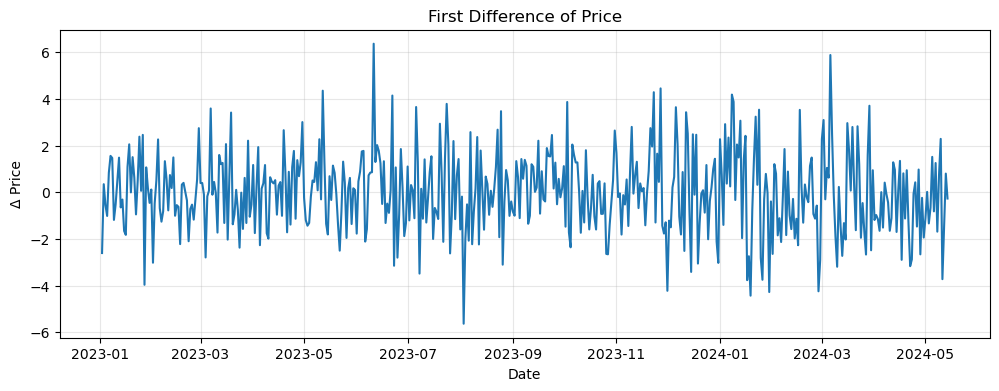

ADF test on Differenced Price:
  Test statistic: -21.4086
  p-value:        0.0000
  Decision @ 0.05: Reject unit root (stationary)

Correlation between ΔPrice and Returns(%): 0.9937
Note: ΔPrice is in price units; Returns is in percent; correlation should still be positive but not necessarily near 1.


<Figure size 1200x400 with 0 Axes>

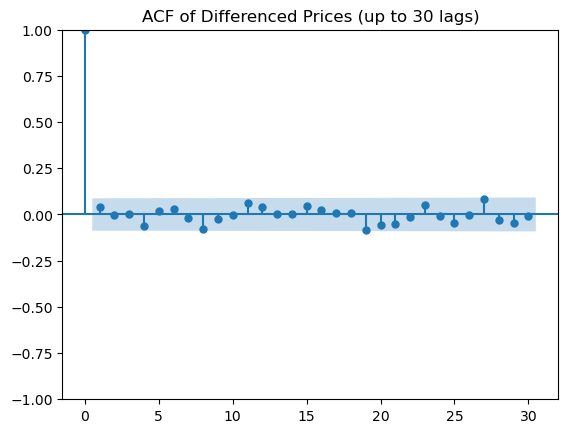

In [11]:

diff_price = df_stock['Price'].diff().dropna()

plt.figure(figsize=(12,4))
plt.plot(diff_price.index, diff_price)
plt.title("First Difference of Price")
plt.xlabel("Date")
plt.ylabel("Δ Price")
plt.grid(True, alpha=0.3)
plt.show()

# ADF on differenced series
adf_stat_d, adf_p_d, _, _, adf_crit_d, _ = adfuller(diff_price)
print("ADF test on Differenced Price:")
print(f"  Test statistic: {adf_stat_d:.4f}")
print(f"  p-value:        {adf_p_d:.4f}")
print("  Decision @ 0.05:", "Reject unit root (stationary)" if adf_p_d < 0.05 else "Fail to reject (non-stationary)")

# Compare with returns
ret = df_stock['Returns'].iloc[1:]  # align with diff_price length
corr = np.corrcoef(diff_price.values, ret.values)[0,1]
print(f"\nCorrelation between ΔPrice and Returns(%): {corr:.4f}")
print("Note: ΔPrice is in price units; Returns is in percent; correlation should still be positive but not necessarily near 1.")

# ACF of differenced prices
plt.figure(figsize=(12,4))
plot_acf(diff_price, lags=30)
plt.title("ACF of Differenced Prices (up to 30 lags)")
plt.show()


### B3: ACF and PACF Analysis (Returns)

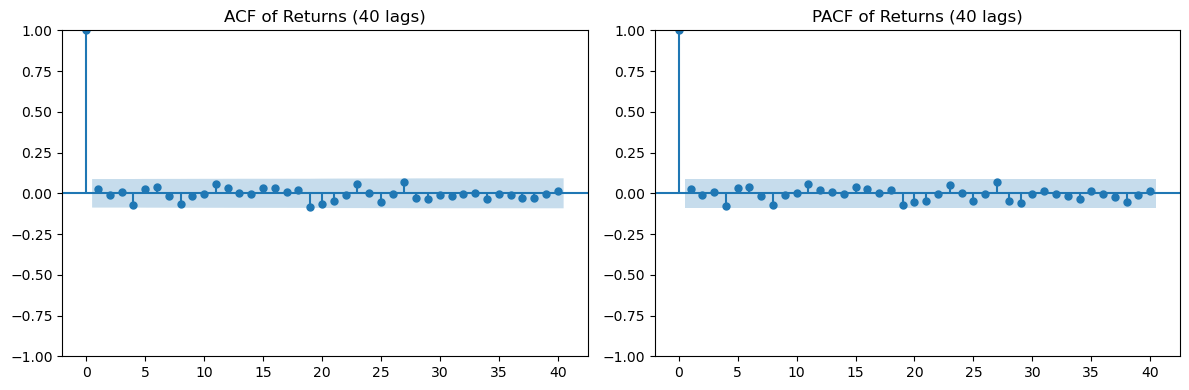

rho(1) = Corr(r_t, r_(t-1)) = 0.0238
rho(5) = Corr(r_t, r_(t-5)) = 0.0273

Suggested orders (rule of thumb):
- If PACF cuts off after lag 1 and ACF decays: AR(1).
- If ACF cuts off after lag 1 and PACF decays: MA(1).
- If both decay: ARMA(1,1) is a reasonable candidate.


In [12]:

returns_series = df_stock['Returns']

fig, axes = plt.subplots(1, 2, figsize=(12,4))
plot_acf(returns_series, lags=40, ax=axes[0])
plot_pacf(returns_series, lags=40, ax=axes[1], method='ywm')
axes[0].set_title("ACF of Returns (40 lags)")
axes[1].set_title("PACF of Returns (40 lags)")
plt.tight_layout()
plt.show()

# Manual autocorrelations rho(1), rho(5)
r = returns_series.values
rho1 = np.corrcoef(r[1:], r[:-1])[0,1]
rho5 = np.corrcoef(r[5:], r[:-5])[0,1]
print(f"rho(1) = Corr(r_t, r_(t-1)) = {rho1:.4f}")
print(f"rho(5) = Corr(r_t, r_(t-5)) = {rho5:.4f}")

print("\nSuggested orders (rule of thumb):")
print("- If PACF cuts off after lag 1 and ACF decays: AR(1).")
print("- If ACF cuts off after lag 1 and PACF decays: MA(1).")
print("- If both decay: ARMA(1,1) is a reasonable candidate.")


### B4: AR(p) Model Estimation

                               SARIMAX Results                                
Dep. Variable:                Returns   No. Observations:                  500
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -902.468
Date:                Wed, 11 Feb 2026   AIC                           1810.936
Time:                        17:34:54   BIC                           1823.579
Sample:                    01-01-2023   HQIC                          1815.897
                         - 05-14-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.068      0.022      0.983      -0.132       0.135
ar.L1          0.0237      0.046      0.516      0.606      -0.066       0.114
sigma2         2.1641      0.129     16.770      0.0

,Model,AIC,BIC,LogLik
0,AR(1),1810.935654,1823.579478,-902.467827
1,AR(2),1812.849002,1829.707434,-902.424501
2,AR(3),1814.805189,1835.878229,-902.402594


Preferred AR by AIC: AR(1)


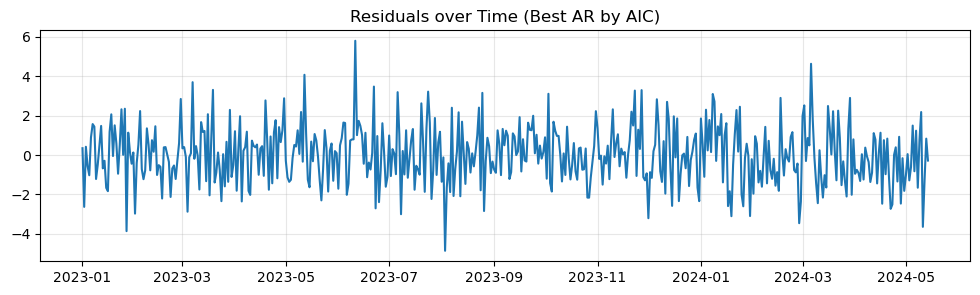

<Figure size 1200x300 with 0 Axes>

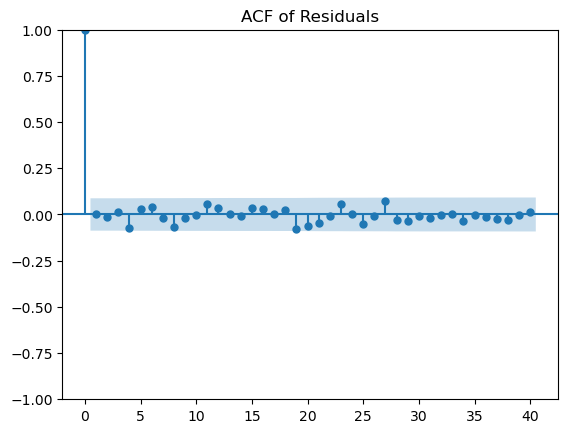


Ljung-Box test (null: no autocorrelation):


,lb_stat,lb_pvalue
10,6.853996,0.739153
20,15.972778,0.718312


In [13]:

# AR(1)
ar1 = ARIMA(returns_series, order=(1,0,0)).fit()
print(ar1.summary())

phi1 = ar1.params.get('ar.L1', np.nan)
pval_phi1 = ar1.pvalues.get('ar.L1', np.nan)
print(f"\nAR(1) phi1 = {phi1:.4f}, p-value = {pval_phi1:.4f}")
print("Stationarity condition |phi1| < 1:", abs(phi1) < 1)

# AR(2), AR(3) compare AIC
ar2 = ARIMA(returns_series, order=(2,0,0)).fit()
ar3 = ARIMA(returns_series, order=(3,0,0)).fit()

aic_table = pd.DataFrame({
    'Model': ['AR(1)', 'AR(2)', 'AR(3)'],
    'AIC': [ar1.aic, ar2.aic, ar3.aic],
    'BIC': [ar1.bic, ar2.bic, ar3.bic],
    'LogLik': [ar1.llf, ar2.llf, ar3.llf]
}).sort_values('AIC')
display(aic_table)

best_ar = {'AR(1)': ar1, 'AR(2)': ar2, 'AR(3)': ar3}[aic_table.iloc[0]['Model']]
print(f"Preferred AR by AIC: {aic_table.iloc[0]['Model']}")

# Residual diagnostics
resid = best_ar.resid
plt.figure(figsize=(12,3))
plt.plot(resid)
plt.title("Residuals over Time (Best AR by AIC)")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(12,3))
plot_acf(resid, lags=40)
plt.title("ACF of Residuals")
plt.show()

lb = acorr_ljungbox(resid, lags=[10, 20], return_df=True)
print("\nLjung-Box test (null: no autocorrelation):")
display(lb)


### B5: MA(q) Model Estimation

                               SARIMAX Results                                
Dep. Variable:                Returns   No. Observations:                  500
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -902.464
Date:                Wed, 11 Feb 2026   AIC                           1810.928
Time:                        17:34:55   BIC                           1823.572
Sample:                    01-01-2023   HQIC                          1815.889
                         - 05-14-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.068      0.022      0.983      -0.132       0.135
ma.L1          0.0244      0.046      0.530      0.596      -0.066       0.115
sigma2         2.1640      0.129     16.771      0.0

,Model,AIC,BIC,LogLik
1,MA(1),1810.928056,1823.571880,-902.464028
0,AR(1),1810.935654,1823.579478,-902.467827


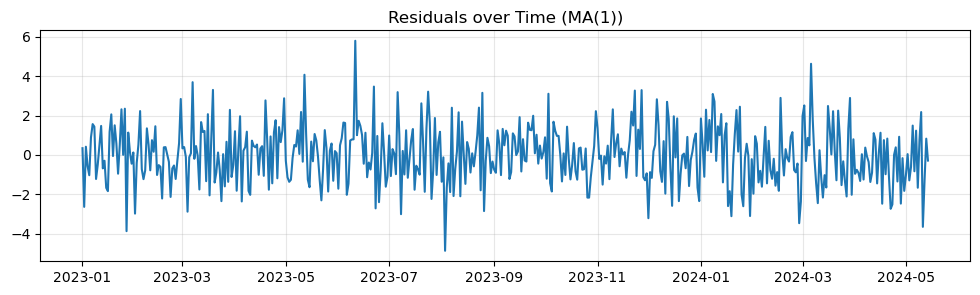

<Figure size 1200x300 with 0 Axes>

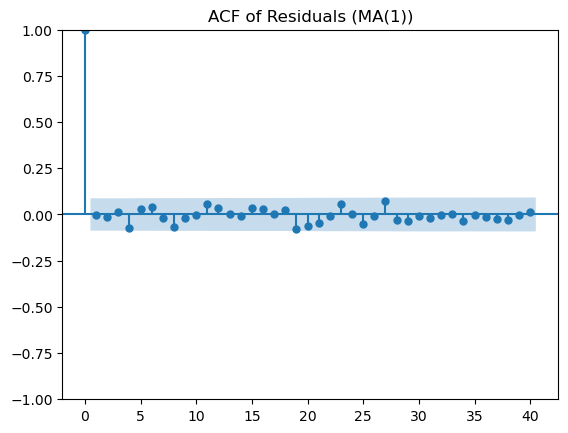


Ljung-Box test (MA(1) residuals):


,lb_stat,lb_pvalue
10,6.840982,0.740367
20,15.950224,0.719707


In [14]:

ma1 = ARIMA(returns_series, order=(0,0,1)).fit()
print(ma1.summary())

theta1 = ma1.params.get('ma.L1', np.nan)
pval_theta1 = ma1.pvalues.get('ma.L1', np.nan)
print(f"\nMA(1) theta1 = {theta1:.4f}, p-value = {pval_theta1:.4f}")
print("Invertibility condition |theta1| < 1:", abs(theta1) < 1)

# Compare MA(1) vs AR(1)
cmp = pd.DataFrame({
    'Model': ['AR(1)', 'MA(1)'],
    'AIC': [ar1.aic, ma1.aic],
    'BIC': [ar1.bic, ma1.bic],
    'LogLik': [ar1.llf, ma1.llf]
}).sort_values('AIC')
display(cmp)

# Residual diagnostics for MA(1)
resid_ma = ma1.resid
plt.figure(figsize=(12,3))
plt.plot(resid_ma)
plt.title("Residuals over Time (MA(1))")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(12,3))
plot_acf(resid_ma, lags=40)
plt.title("ACF of Residuals (MA(1))")
plt.show()

lb_ma = acorr_ljungbox(resid_ma, lags=[10, 20], return_df=True)
print("\nLjung-Box test (MA(1) residuals):")
display(lb_ma)


### B6: ARMA(p,q) Model (ARMA(1,1))

In [15]:

arma11 = ARIMA(returns_series, order=(1,0,1)).fit()
print(arma11.summary())

# Compare AIC with AR(1) and MA(1)
cmp2 = pd.DataFrame({
    'Model': ['AR(1)', 'MA(1)', 'ARMA(1,1)'],
    'AIC': [ar1.aic, ma1.aic, arma11.aic],
    'BIC': [ar1.bic, ma1.bic, arma11.bic],
    'LogLik': [ar1.llf, ma1.llf, arma11.llf],
    'NumParams': [len(ar1.params), len(ma1.params), len(arma11.params)]
}).sort_values('AIC')
display(cmp2)

print("\nOverparameterization check (ARMA(1,1)):")
print("p-values:")
display(arma11.pvalues)

print("Rule of thumb: if one of ar.L1 or ma.L1 is not significant, a simpler AR(1) or MA(1) may be preferred.")

# Comparison table requested
comp_table = cmp2.copy()
display(comp_table)


                               SARIMAX Results                                
Dep. Variable:                Returns   No. Observations:                  500
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -901.801
Date:                Wed, 11 Feb 2026   AIC                           1811.602
Time:                        17:33:00   BIC                           1828.461
Sample:                    01-01-2023   HQIC                          1818.217
                         - 05-14-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.068      0.022      0.982      -0.131       0.134
ar.L1         -0.8346      0.229     -3.651      0.000      -1.283      -0.387
ma.L1          0.8659      0.209      4.141      0.0

,Model,AIC,BIC,LogLik,NumParams
1,MA(1),1810.928056,1823.571880,-902.464028,3
0,AR(1),1810.935654,1823.579478,-902.467827,3
2,"ARMA(1,1)",1811.602199,1828.460631,-901.801099,4



Overparameterization check (ARMA(1,1)):
p-values:


const     9.823319e-01
ar.L1     2.610642e-04
ma.L1     3.460997e-05
sigma2    4.894166e-63
dtype: float64

Rule of thumb: if one of ar.L1 or ma.L1 is not significant, a simpler AR(1) or MA(1) may be preferred.


,Model,AIC,BIC,LogLik,NumParams
1,MA(1),1810.928056,1823.571880,-902.464028,3
0,AR(1),1810.935654,1823.579478,-902.467827,3
2,"ARMA(1,1)",1811.602199,1828.460631,-901.801099,4


### B7: Automatic ARIMA Selection (Grid Search over p,q in [0,5])

In [16]:

# Fast automatic selection using arma_order_select_ic (evaluates AIC over p,q up to 5)
# Returns are already (approximately) stationary, so d=0.
sel = arma_order_select_ic(returns_series, max_ar=5, max_ma=5, ic=['aic'], trend='n')
best_p, best_q = sel.aic_min_order
best_order = (best_p, 0, best_q)

print("AIC grid (rows=AR order p, cols=MA order q):")
display(sel.aic)

print(f"\nBest (p,d,q) by AIC: {best_order}, AIC={sel.aic[best_p][best_q]:.3f}")

best_fit = ARIMA(returns_series, order=best_order).fit()
print(best_fit.summary())

print("\nDoes automatic selection match manual identification?")
print("- If ACF/PACF suggested a small AR/MA effect, the selected (p,q) should be small as well.")


AIC grid (rows=AR order p, cols=MA order q):


,0,1,2,3,4,5
0,1807.218592,1808.928544,1810.826329,1812.743711,1811.431632,1813.152642
1,1808.936141,1809.602714,1811.584517,1813.395591,1813.288536,1814.962029
2,1810.849534,1811.583610,1813.595275,1809.555582,1808.670469,1811.193962
3,1812.805677,1813.397428,1809.531509,1809.099266,1810.181287,1812.422121
4,1811.920746,1813.676849,1808.756698,1810.394149,1812.729886,1814.221926
5,1813.420849,1815.224331,1811.126575,1813.972971,1813.989237,1816.179573



Best (p,d,q) by AIC: (np.int64(0), 0, np.int64(0)), AIC=1807.219
                               SARIMAX Results                                
Dep. Variable:                Returns   No. Observations:                  500
Model:                          ARIMA   Log Likelihood                -902.609
Date:                Wed, 11 Feb 2026   AIC                           1809.218
Time:                        17:33:07   BIC                           1817.647
Sample:                    01-01-2023   HQIC                          1812.526
                         - 05-14-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.066      0.022      0.982      -0.128       0.131
sigma2         2.1653      0.129     16.762      0.000       1.91

### B8: Forecasting with Best ARIMA Model

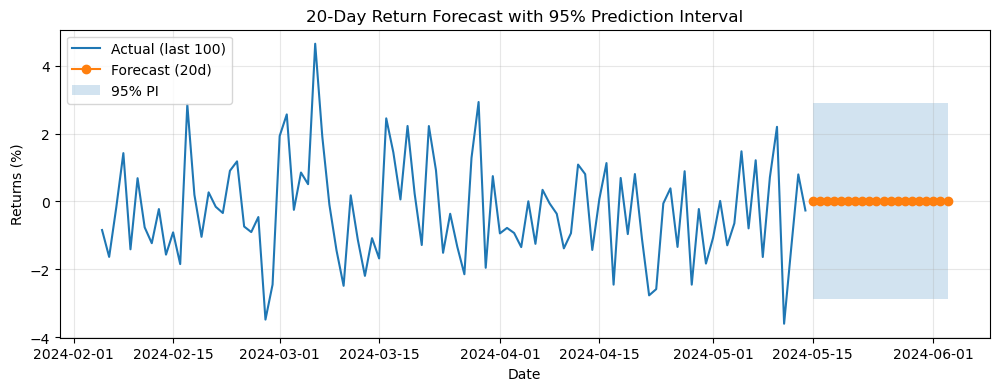

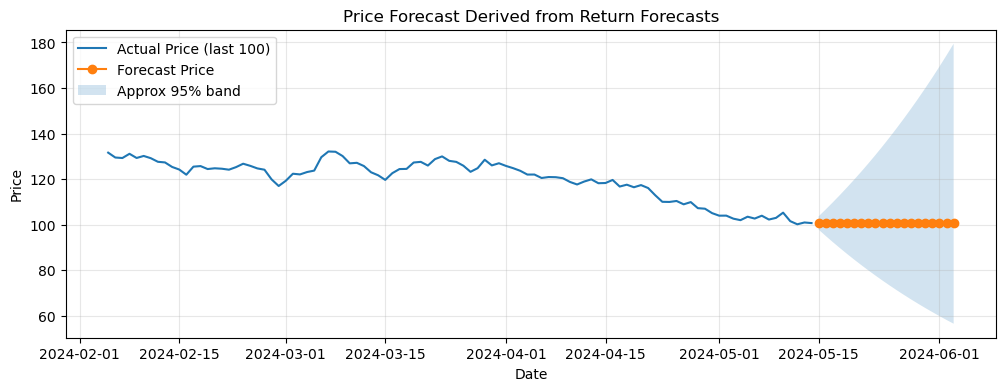

Observations:
- For stationary return models, multi-step forecasts often revert toward the mean (near 0%).
- Prediction intervals widen with horizon because uncertainty accumulates over future steps.


In [17]:

# 20-day ahead forecasts for returns (percent)
h = 20
fc_res = best_fit.get_forecast(steps=h)
fc_mean = fc_res.predicted_mean
fc_ci = fc_res.conf_int(alpha=0.05)

# Plot last 100 days of actual returns + forecast
last_n = 100
plt.figure(figsize=(12,4))
plt.plot(returns_series.index[-last_n:], returns_series.iloc[-last_n:], label='Actual (last 100)')
plt.plot(fc_mean.index, fc_mean.values, marker='o', label='Forecast (20d)')
plt.fill_between(fc_mean.index, fc_ci.iloc[:,0].values, fc_ci.iloc[:,1].values, alpha=0.2, label='95% PI')
plt.title("20-Day Return Forecast with 95% Prediction Interval")
plt.xlabel("Date")
plt.ylabel("Returns (%)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Convert return forecasts to price forecasts
# Returns are in percent, convert to decimal log-returns approx (since we built price via exp(cumsum(returns_decimal))).
last_price = df_stock['Price'].iloc[-1]
ret_dec = fc_mean.values / 100.0
price_path = last_price * np.exp(np.cumsum(ret_dec))
price_fc = pd.Series(price_path, index=fc_mean.index, name='PriceForecast')

# Approximate price interval by mapping return CI through same transform (independent step approximation)
ci_low_dec = fc_ci.iloc[:,0].values / 100.0
ci_high_dec = fc_ci.iloc[:,1].values / 100.0
price_low = last_price * np.exp(np.cumsum(ci_low_dec))
price_high = last_price * np.exp(np.cumsum(ci_high_dec))

plt.figure(figsize=(12,4))
plt.plot(df_stock.index[-last_n:], df_stock['Price'].iloc[-last_n:], label='Actual Price (last 100)')
plt.plot(price_fc.index, price_fc.values, marker='o', label='Forecast Price')
plt.fill_between(price_fc.index, price_low, price_high, alpha=0.2, label='Approx 95% band')
plt.title("Price Forecast Derived from Return Forecasts")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print("Observations:")
print("- For stationary return models, multi-step forecasts often revert toward the mean (near 0%).")
print("- Prediction intervals widen with horizon because uncertainty accumulates over future steps.")
